In [1]:
from pathlib import Path
import json
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
from rastermap import Rastermap, utils
from tqdm import tqdm
from scipy.stats import zscore

root = "C://Users//Josh Selfe//OneDrive - Nexus365//Other Documents//Neuromatch"

sup_bef = 'VR2_2021_03_20_1' #example mouse before supervised learning
sup_aft = 'VR2_2021_04_06_1' #example mouse after supervised learning
unsup_bef = 'TX105_2022_10_08_2' #example mouse before supervised learning
unsup_aft = 'TX105_2022_10_19_2' #example mouse after supervised learning
sup_test1 = 'VR2_2021_04_11_1' #example mouse after supervised learning, test 1

In [ ]:
# read behavioural variables in 

Beh_test_1 = np.load(os.path.join(root, 'Beh_sup_test1.npy'), allow_pickle=1).item()
beh = Beh_test_1 ['VR2_2021_04_11_1']

ntrials = beh['ntrials'] # number of trials
WallName = beh['WallName'] # name of wall for each frame
cum_pos_fr = beh['ft_PosCum'] # cumulative position in decimeters for each frame

RewPos = beh['RewPos'] # position of reward in corridor
SoundPos = beh['SoundPos'] # position of sound cue in corridor 



In [ ]:
# read neural data in and go from PCA space back to neural space
svd_dec_400pc = np.load(os.path.join(root, sup_test1 +'_SVD_dec.npy'), allow_pickle=1).item() # 400 PCs
spks = svd_dec_400pc['U'][:, :].T @ svd_dec_400pc['V'] # project from the PC space back to neural space (only do it for the first 1000 neuorns)

spks = zscore(spks, axis=1) 

nfrs = spks.shape[1] # number of frames

c:\Users\Josh Selfe\.conda\envs\correct_neuromatch\Lib\site-packages\sklearn\base.py:440: InconsistentVersionWarning: Trying to unpickle estimator TruncatedSVD from version 1.6.0 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [ ]:
# plot some neurons for sanity check
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.plot(spks[i], label=f'Neuron {i+1}')

plt.xlabel("Time (or frame index)")
plt.ylabel("Fluorescence")
plt.title("Fluorescence traces of first 10 neurons")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
# interpolate into neurons*trials*decimeters
from scipy import interpolate
import pdb;
def interp_value(v, vind, tind):
    """v: value; vind: index; tind: target index"""
    #pdb.set_trace()
    Model_ = interpolate.interp1d(vind, v, fill_value='extrapolate')
    return Model_(tind)

max_cum_pos = ntrials * 60 # length of corrior is 60 decimeters (6 meters)
interp_spk = np.empty((spks.shape[0], max_cum_pos))
for i in range(spks.shape[0]):
    interp_spk[i] = interp_value(spks[i], cum_pos_fr[:nfrs], np.arange(max_cum_pos))
interp_spk = interp_spk.reshape((interp_spk.shape[0], ntrials, 60))

c:\Users\Josh Selfe\.conda\envs\correct_neuromatch\Lib\site-packages\scipy\interpolate\_interpolate.py:497: RuntimeWarning: divide by zero encountered in divide
  slope = (y_hi - y_lo) / (x_hi - x_lo)[:, None]
c:\Users\Josh Selfe\.conda\envs\correct_neuromatch\Lib\site-packages\scipy\interpolate\_interpolate.py:500: RuntimeWarning: invalid value encountered in multiply
  y_new = slope*(x_new - x_lo)[:, None] + y_lo


In [ ]:
subset = interp_spk[:1000, :, :]  # only take the first 1000 neurons for further processing
interp_spk = subset  # use the subset for further processing

# del spks, interp_spk  # free up memory

In [15]:
# get the trials for each wall type
leaf1_mask = WallName == 'leaf1'
leaf2_mask = WallName == 'leaf2'

# Extract trials along axis=1 (trial axis)
leaf1_trials = interp_spk[:, leaf1_mask, :]
leaf2_trials = interp_spk[:, leaf2_mask, :]

In [16]:
RewPosLeaf1 = RewPos[leaf1_mask]  # reward position for leaf1 trials
SoundPosLeaf1 = SoundPos[leaf1_mask]  # sound position for leaf1 trials
RewPosLeaf2 = RewPos[leaf2_mask]  # reward position for leaf2 trials
SoundPosLeaf2 = SoundPos[leaf2_mask]  # sound position for leaf2

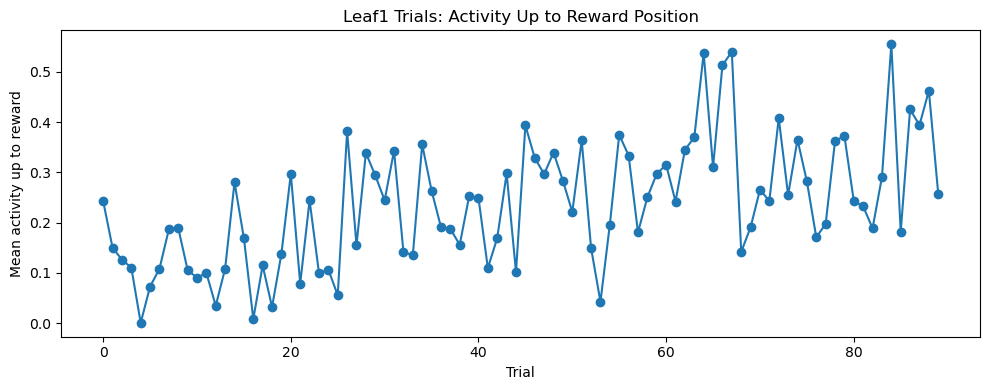

In [ ]:
# plot the average activity up to the reward position for leaf2 trials

mean_across_neurons = leaf2_trials.mean(axis=0)  # shape: (264, 60)

# Initialize result array
trial_means = np.zeros(mean_across_neurons.shape[0])  # shape: (264,)

# Loop over trials and average up to reward position
for i in range(mean_across_neurons.shape[0]):
    end = int(RewPosLeaf2[i])  # exclusive
    if end > 0:
        trial_means[i] = mean_across_neurons[i, :end].mean()
    else:
        trial_means[i] = np.nan  # or 0, if you prefer

# Plot
plt.figure(figsize=(10, 4))
plt.plot(trial_means, marker='o')
plt.xlabel("Trial")
plt.ylabel("Mean activity up to reward")
plt.title("Leaf2 Trials: Activity Up to Reward Position")
plt.tight_layout()
plt.show()